# Train a classifier to determine product seasonality


Import all necessary libraries.


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

from xgboost import XGBClassifier

from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
from azureml.train.automl import AutoMLConfig
from azureml.automl.runtime.onnx_convert import OnnxConverter
from azureml.core.model import Model
from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice

StatementMeta(SparkPool01, 27, 1, Finished, Available)

## Exploratory data analysis (basic stats)

Create Spark temporary views for sales and products.

In [26]:
%%spark
val df = spark.read.sqlanalytics("SQLPool01.wwi_mcw.SaleSmall") 
df.createOrReplaceTempView("sale")


val df2 = spark.read.sqlanalytics("SQLPool01.wwi_mcw.Product") 
df2.createOrReplaceTempView("product")
display(df2)

StatementMeta(SparkPool01, 27, 11, Finished, Available)

df: org.apache.spark.sql.DataFrame = [TransactionId: string, CustomerId: int ... 9 more fields]
df2: org.apache.spark.sql.DataFrame = [ProductId: smallint, Seasonality: int ... 2 more fields]


SynapseWidget(Synapse.DataFrame, af337eb3-fc4d-483b-a6b5-979cabd4cf88)

Load daily product sales from the SQL pool.


In [35]:
sqlQuery = """
SELECT
    P.ProductId
    ,P.Seasonality
    ,S.TransactionDateId
    ,COUNT(*) as TransactionItemsCount
FROM
    sale S
    JOIN product P ON
        S.ProductId = P.ProductId
where TransactionDateId between 20190101 and 20191231
GROUP BY
    P.ProductId
    ,P.Seasonality
    ,S.TransactionDateId
"""

prod_df = spark.sql(sqlQuery)
prod_df.cache()
prod_df.show()

StatementMeta(SparkPool01, 27, 20, Finished, Available)

Check the number of records in the data frame (should be around 1.3 million rows).

In [36]:
prod_df.count()

StatementMeta(SparkPool01, 27, 21, Finished, Available)

Display some statistics about the data frame.


In [37]:
display(prod_df.describe())

StatementMeta(SparkPool01, 27, 22, Finished, Available)

SynapseWidget(Synapse.DataFrame, d0c4f9d1-9ad2-418b-800f-aa5297d6dfe3)

Pivot the data frame to make daily sale items counts columns. 


In [38]:
prod_prep_df = prod_df.groupBy(['ProductId', 'Seasonality']).pivot('TransactionDateId').sum('TransactionItemsCount').toPandas()

StatementMeta(SparkPool01, 27, 23, Finished, Available)

Clean up the nulls and take a look at the result.


In [39]:
prod_prep_df = prod_prep_df.fillna(0)
prod_prep_df.head(10)

StatementMeta(SparkPool01, 27, 24, Finished, Available)

Isolate features and prediction classes.

Standardize features by removing the mean and scaling to unit variance.


In [40]:
X = prod_prep_df.iloc[:, 2:].values
y = prod_prep_df['Seasonality'].values

X_scale = StandardScaler().fit_transform(X)

StatementMeta(SparkPool01, 27, 25, Finished, Available)

## Use PCA for dimensionality reduction

Perform dimensionality reduction using Principal Components Analysis and two target components.


In [42]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scale)
principal_components = MinMaxScaler().fit_transform(principal_components)

pca_df = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2'])
pca_df = pd.concat([pca_df, prod_prep_df[['Seasonality']]], axis = 1)

StatementMeta(SparkPool01, 27, 27, Finished, Available)

Display the products data frame in two dimensions (mapped to the two principal components).

Note the clear separation of clusters.


StatementMeta(SparkPool01, 27, 28, Finished, Available)

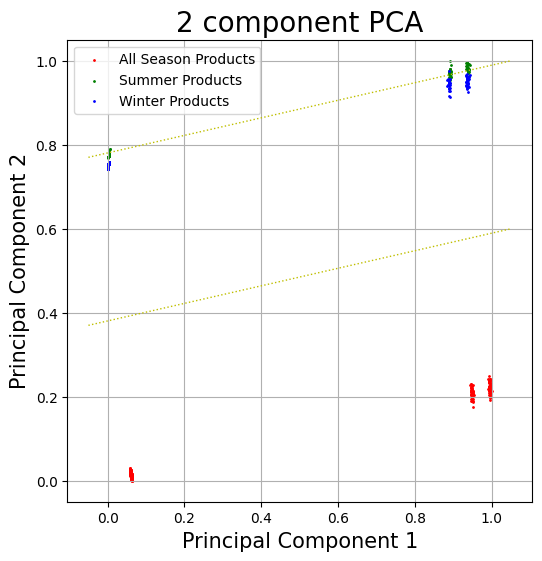

In [43]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 2, 3]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['Seasonality'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'pc1']
               , pca_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 1)
ax.legend(['All Season Products', 'Summer Products', 'Winter Products'])
ax.plot([-0.05, 1.05], [0.77, 1.0], linestyle=':', linewidth=1, color='y')
ax.plot([-0.05, 1.05], [0.37, 0.6], linestyle=':', linewidth=1, color='y')
ax.grid()

plt.show()
plt.close()

Redo the Principal Components Analysis, this time with twenty dimensions.


In [44]:
def col_name(x):
    return f'f{x:02}'

pca = PCA(n_components=20)
principal_components = pca.fit_transform(X_scale)
principal_components = MinMaxScaler().fit_transform(principal_components)

X = pd.DataFrame(data = principal_components, columns = list(map(col_name, np.arange(0, 20))))
pca_df = pd.concat([X, prod_prep_df[['ProductId']]], axis = 1)
pca_automl_df = pd.concat([X, prod_prep_df[['Seasonality']]], axis = 1)

X = X[:4500]
y = prod_prep_df['Seasonality'][:4500]
pca_automl_df = pca_automl_df[:4500]

StatementMeta(SparkPool01, 27, 29, Finished, Available)

Save the PCA components to the SQL pool (you may ignore any warnings).


In [45]:
pca_sdf = spark.createDataFrame(pca_df)
pca_sdf.createOrReplaceTempView("productpca")

StatementMeta(SparkPool01, 27, 30, Finished, Available)

In [46]:
%%spark
val df = spark.sqlContext.sql("select * from productpca")
df.write.sqlanalytics("SQLPool01.wwi_mcw.ProductPCA", Constants.INTERNAL)

StatementMeta(SparkPool01, 27, 31, Finished, Available)

## Train ensemble of trees classifier (using XGBoost)

Split into test and training data sets.


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

StatementMeta(SparkPool01, 27, 32, Finished, Available)

Train the ensemble classifier using XGBoost.


In [48]:
model = XGBClassifier()
model.fit(X_train, y_train)

StatementMeta(SparkPool01, 27, 33, Finished, Available)

Perform predictions with the newly trained model.


In [49]:
y_pred = model.predict(X_test)

StatementMeta(SparkPool01, 27, 34, Finished, Available)

Calculate the accuracy of the model using test data.


In [50]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

StatementMeta(SparkPool01, 27, 35, Finished, Available)

## Train classifier using Auto ML


Configure the connection to the Azure Machine Learning workspace. 

Please add your subscriptionID, Resource Group name and Azure machine Learning Workspace name which can be found in the Azure Portal

In [20]:
subscription_id= '<Subscription ID>'
resource_group= '<Resource Group>'
workspace_name= '<AML Workspace Name>'
ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
ws.write_config()

experiment = Experiment(ws, "ASAMCW_Product_Seasonality")

StatementMeta(SparkPool01, 19, 21, Finished, Available)

Configure the Automated Machine Learning experiment and start it (will run on local compute resources). It will take approximately 15 minutes.

Note we set enable_onnx_compatible_models=True to produce an ONNX model output

In [52]:
automl_classifier_config = AutoMLConfig(
        task='classification',        
        experiment_timeout_minutes=15,
        enable_onnx_compatible_models=True,
        training_data=pca_automl_df,
        label_column_name='Seasonality',
        n_cross_validations=5,
        enable_voting_ensemble=False,
        enable_stack_ensemble=False
        )

local_run = experiment.submit(automl_classifier_config, show_output=True)

StatementMeta(SparkPool01, 27, 37, Finished, Available)

## Operationalize
Operationalization means getting the model into the cloud so that others can run it after you close the notebook. 

While you can create a docker container running on Azure Container Instances (ACI) to host the model, we want to host the model in Synapse Analytics so it can be called from T-SQL Predict function to easily enrich your SQL Pool data.
PREDICT() requires the model to be in ONNX format so we need to retrieve the best ONNX model from the AutoML pipeline iterations. The model is then registered with Azure Machine Learning model registery. 

We will later use the ONNX model for inferencing in Azure Synapse SQL Pool using the new model scoring wizard.

Retrieve the Best ONNX Model

The get_output method returns the best run (best_run) and the fitted model (onnx_mdl). The Model includes the pipeline and any pre-processing.

In [53]:
best_run, onnx_mdl = local_run.get_output(return_onnx_model=True)

StatementMeta(SparkPool01, 27, 38, Finished, Available)

Save the best ONNX model

In [54]:
from azureml.automl.runtime.onnx_convert import OnnxConverter
onnx_fl_path = "./best_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

StatementMeta(SparkPool01, 27, 39, Finished, Available)

Register model with Azure Machine Learning model registery using MLflow


In [55]:
import mlflow
import mlflow.onnx
import pandas

from mlflow.models.signature import infer_signature

experiment_name = 'ASAMCW_Product_Seasonality'
artifact_path = 'ASAMCW_Product_Seasonality_artifact'

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    # Infer signature
    input_sample = X_train.head(1)
    output_sample = pandas.DataFrame(columns=['output_label'], data=[1])
    signature = infer_signature(input_sample, output_sample)

    # Save the model to the outputs directory for capture
    mlflow.onnx.log_model(onnx_mdl, artifact_path, signature=signature, input_example=input_sample)

    # Register the model to AML model registry
    mlflow.register_model('runs:/' + run.info.run_id + '/' + artifact_path, 'ASAMCW_Product_Seasonality')

StatementMeta(SparkPool01, 27, 40, Finished, Available)

We can test the model predictions here in the notebook using onnxruntime package

In [56]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

import onnxruntime
from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

def get_onnx_res(run):
    res_path = 'onnx_resource.json'
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if python_version_compatible:
    test_df = X_test
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    print('Please use Python version 3.6 or 3.7 to run the inference helper.')


StatementMeta(SparkPool01, 27, 41, Finished, Available)